# Machine Learning for Loan Default Prediction

In this notebook, we apply several machine learning algorithms to identify customers that will default on their loan. We are going to use five machine learning models suitable for this classification tasks:

- logistic regression,
- random forest


## Dataset

The dataset is contained in the excel file ```data_loan_default.xlsx```. It contains data for 8929 loans issued between January 2007 and September 2017. There are 20 independent variables and one dependent variable. The dependent variable, ```charged_off```, takes value 1 if a customer defaults on his loan and 0 otherwise. Let's first import the relevant libraries and the dataset.

In [89]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, \
    precision_score, f1_score, roc_auc_score, roc_curve, auc, RocCurveDisplay, precision_recall_curve
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC

# Import data
df = pd.read_excel('dataset.xlsx')

df.head()

,loan_amnt,term,installment,emp_length,home_ownership,verification_status,issue_d,purpose,dti,earliest_cr_line,...,pub_rec,revol_util,total_acc,application_type,mort_acc,pub_rec_bankruptcies,log_annual_inc,fico_score,log_revol_bal,charged_off
0,5675,36,189.56,2.0,RENT,Source Verified,2014-12-01,car,15.55,1992,...,0,15.0,15,Individual,0.0,0.0,4.698979,697.0,3.464936,0
1,7000,36,242.63,1.0,RENT,Source Verified,2014-12-01,car,6.78,2002,...,0,69.2,5,Individual,0.0,0.0,4.301052,717.0,3.431364,0
2,3500,36,116.24,10.0,MORTGAGE,Not Verified,2014-12-01,car,10.65,1997,...,0,12.6,35,Individual,2.0,0.0,4.681250,742.0,3.765520,0
3,10000,36,316.47,10.0,MORTGAGE,Not Verified,2014-12-01,car,21.74,1996,...,0,23.7,22,Individual,4.0,0.0,4.875067,707.0,3.424555,0
4,1500,36,46.31,2.0,OWN,Not Verified,2014-12-01,car,12.17,1997,...,0,46.5,13,Individual,2.0,0.0,4.812920,712.0,4.448211,0


Let's check the proportion of loans in each class.

In [90]:
df['charged_off'].value_counts(normalize=True)

0    0.852055
1    0.147945
Name: charged_off, dtype: float64

In [91]:
df.shape

(8929, 21)

We notice that our dataset is imbalanced. Therefore, we will need to take that into account when training the models.

## Data preprocessing

### Feature engineering

First, we notice that the ```earliest_cr_line``` variable provides the date of the earliest credit line of the customer. However, this does not provide any useful information because the loans are issued at different dates. Therefore, we transform this variable to obtain the number of years between the earliest credit line and the loan issue date. 

In [92]:
# Compute years since earliest credit line
df['yr_since_earliest_cr_line'] = pd.DatetimeIndex(df['issue_d']).year - df['earliest_cr_line']
df = df.drop('earliest_cr_line', axis=1)

In [93]:
df.head()

,loan_amnt,term,installment,emp_length,home_ownership,verification_status,issue_d,purpose,dti,open_acc,...,revol_util,total_acc,application_type,mort_acc,pub_rec_bankruptcies,log_annual_inc,fico_score,log_revol_bal,charged_off,yr_since_earliest_cr_line
0,5675,36,189.56,2.0,RENT,Source Verified,2014-12-01,car,15.55,7,...,15.0,15,Individual,0.0,0.0,4.698979,697.0,3.464936,0,22
1,7000,36,242.63,1.0,RENT,Source Verified,2014-12-01,car,6.78,3,...,69.2,5,Individual,0.0,0.0,4.301052,717.0,3.431364,0,12
2,3500,36,116.24,10.0,MORTGAGE,Not Verified,2014-12-01,car,10.65,16,...,12.6,35,Individual,2.0,0.0,4.681250,742.0,3.765520,0,17
3,10000,36,316.47,10.0,MORTGAGE,Not Verified,2014-12-01,car,21.74,7,...,23.7,22,Individual,4.0,0.0,4.875067,707.0,3.424555,0,18
4,1500,36,46.31,2.0,OWN,Not Verified,2014-12-01,car,12.17,8,...,46.5,13,Individual,2.0,0.0,4.812920,712.0,4.448211,0,17


We also notice that the ```purpose``` feature always contains the same value. We remove this feature as it provides no information. Similarly, the ```application_type``` contains the same value for almost 100% of the loans, therefore, we remove the feature. Finally, we want our model to predict default for future issue dates. Therefore, we also remove the ```issue_d``` feature.

In [94]:
# Drop columns
df = df.drop(['purpose', 'issue_d', 'application_type'], axis=1)

### Missing values

Let's compute the fraction of missing values per feature.

In [95]:
df.isnull().sum() / len(df)

loan_amnt                    0.000000
term                         0.000000
installment                  0.000000
emp_length                   0.047598
home_ownership               0.000000
verification_status          0.000000
dti                          0.000000
open_acc                     0.000000
pub_rec                      0.000000
revol_util                   0.001568
total_acc                    0.000000
mort_acc                     0.196663
pub_rec_bankruptcies         0.001904
log_annual_inc               0.000000
fico_score                   0.000000
log_revol_bal                0.000000
charged_off                  0.000000
yr_since_earliest_cr_line    0.000000
dtype: float64

Four of our features contain missing values. The ```mort_acc``` feature contains almost 20% of missing values. Because is this a relatively high proportion, we decide to remove this feature. Both ```emp_length``` and ```revol_util``` contain continuous numeric values. For those features, we replace the missing values by their respective median. For ```pub_rec_bankruptcies```, we set the missing values to zero as is it the value occurring most frequently.

In [96]:
# Impute missing values
df = df.drop('mort_acc', axis=1)
df['emp_length'] = df['emp_length'].fillna(df['emp_length'].mean())
df['revol_util'] = df['revol_util'].fillna(df['revol_util'].median())
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].fillna(0)

In [97]:
import pandas as pd

# Assuming 'df' is your pandas DataFrame containing both categorical and numeric columns
# You can adjust this based on your actual DataFrame name

# Get column names and their data types
column_types = df.dtypes

# Extract names of categorical columns (non-numeric data types)
categorical_columns = column_types[column_types == 'object'].index.tolist()

# Print the names of categorical columns
print("Categorical Columns:")
for col in categorical_columns:
    print(col)


Categorical Columns:
home_ownership
verification_status


### Categorical variables

We also have two categorical variables, namely ```home_ownership``` and ```verification_status```. Because our machine learning algorithms do not handle categorical variables directly, we one-hot encode them. Note that we drop one of the created dummy variables to reduce multicollinearity. 

In [98]:
# One-hot encoding with inplace=True for modification of original DataFrame
df = pd.get_dummies(df, columns=['home_ownership', 'verification_status'], drop_first=True)

In [99]:
# # Perform one-hot encoding
# df = pd.get_dummies(df, columns=['home_ownership', 'verification_status'], drop_first=True)

# Print the updated DataFrame with one-hot encoded columns
print(df.head())  # Optionally display the first few rows to verify the changes


   loan_amnt  term  installment  emp_length    dti  open_acc  pub_rec  \
0       5675    36       189.56         2.0  15.55         7        0   
1       7000    36       242.63         1.0   6.78         3        0   
2       3500    36       116.24        10.0  10.65        16        0   
3      10000    36       316.47        10.0  21.74         7        0   
4       1500    36        46.31         2.0  12.17         8        0   

   revol_util  total_acc  pub_rec_bankruptcies  log_annual_inc  fico_score  \
0        15.0         15                   0.0        4.698979       697.0   
1        69.2          5                   0.0        4.301052       717.0   
2        12.6         35                   0.0        4.681250       742.0   
3        23.7         22                   0.0        4.875067       707.0   
4        46.5         13                   0.0        4.812920       712.0   

   log_revol_bal  charged_off  yr_since_earliest_cr_line  home_ownership_OWN  \
0       3.46

In [100]:
df.dtypes

loan_amnt                                int64
term                                     int64
installment                            float64
emp_length                             float64
dti                                    float64
open_acc                                 int64
pub_rec                                  int64
revol_util                             float64
total_acc                                int64
pub_rec_bankruptcies                   float64
log_annual_inc                         float64
fico_score                             float64
log_revol_bal                          float64
charged_off                              int64
yr_since_earliest_cr_line                int64
home_ownership_OWN                       uint8
home_ownership_RENT                      uint8
verification_status_Source Verified      uint8
verification_status_Verified             uint8
dtype: object

In [101]:
import pandas as pd

column_types = df.dtypes

# Extract names of categorical columns (non-numeric data types)
categorical_columns = column_types[column_types == 'object'].index.tolist()

# Print the names of categorical columns
print("Categorical Columns:")
for col in categorical_columns:
    print(col)


Categorical Columns:


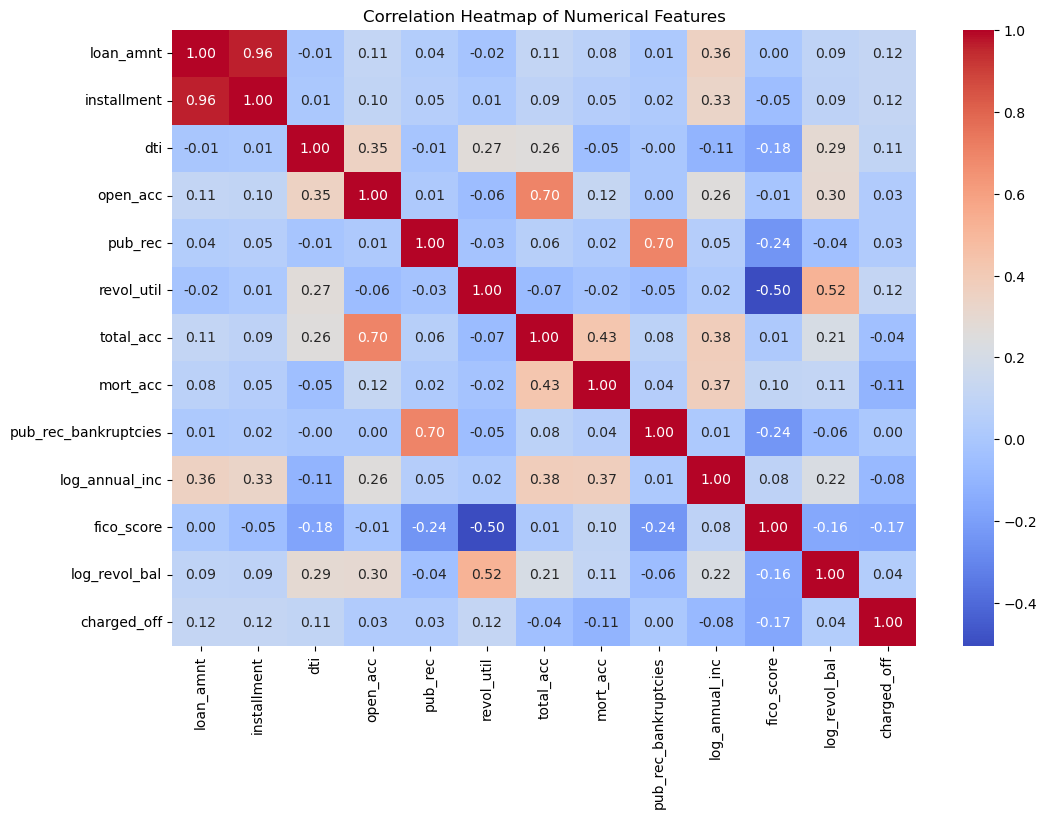

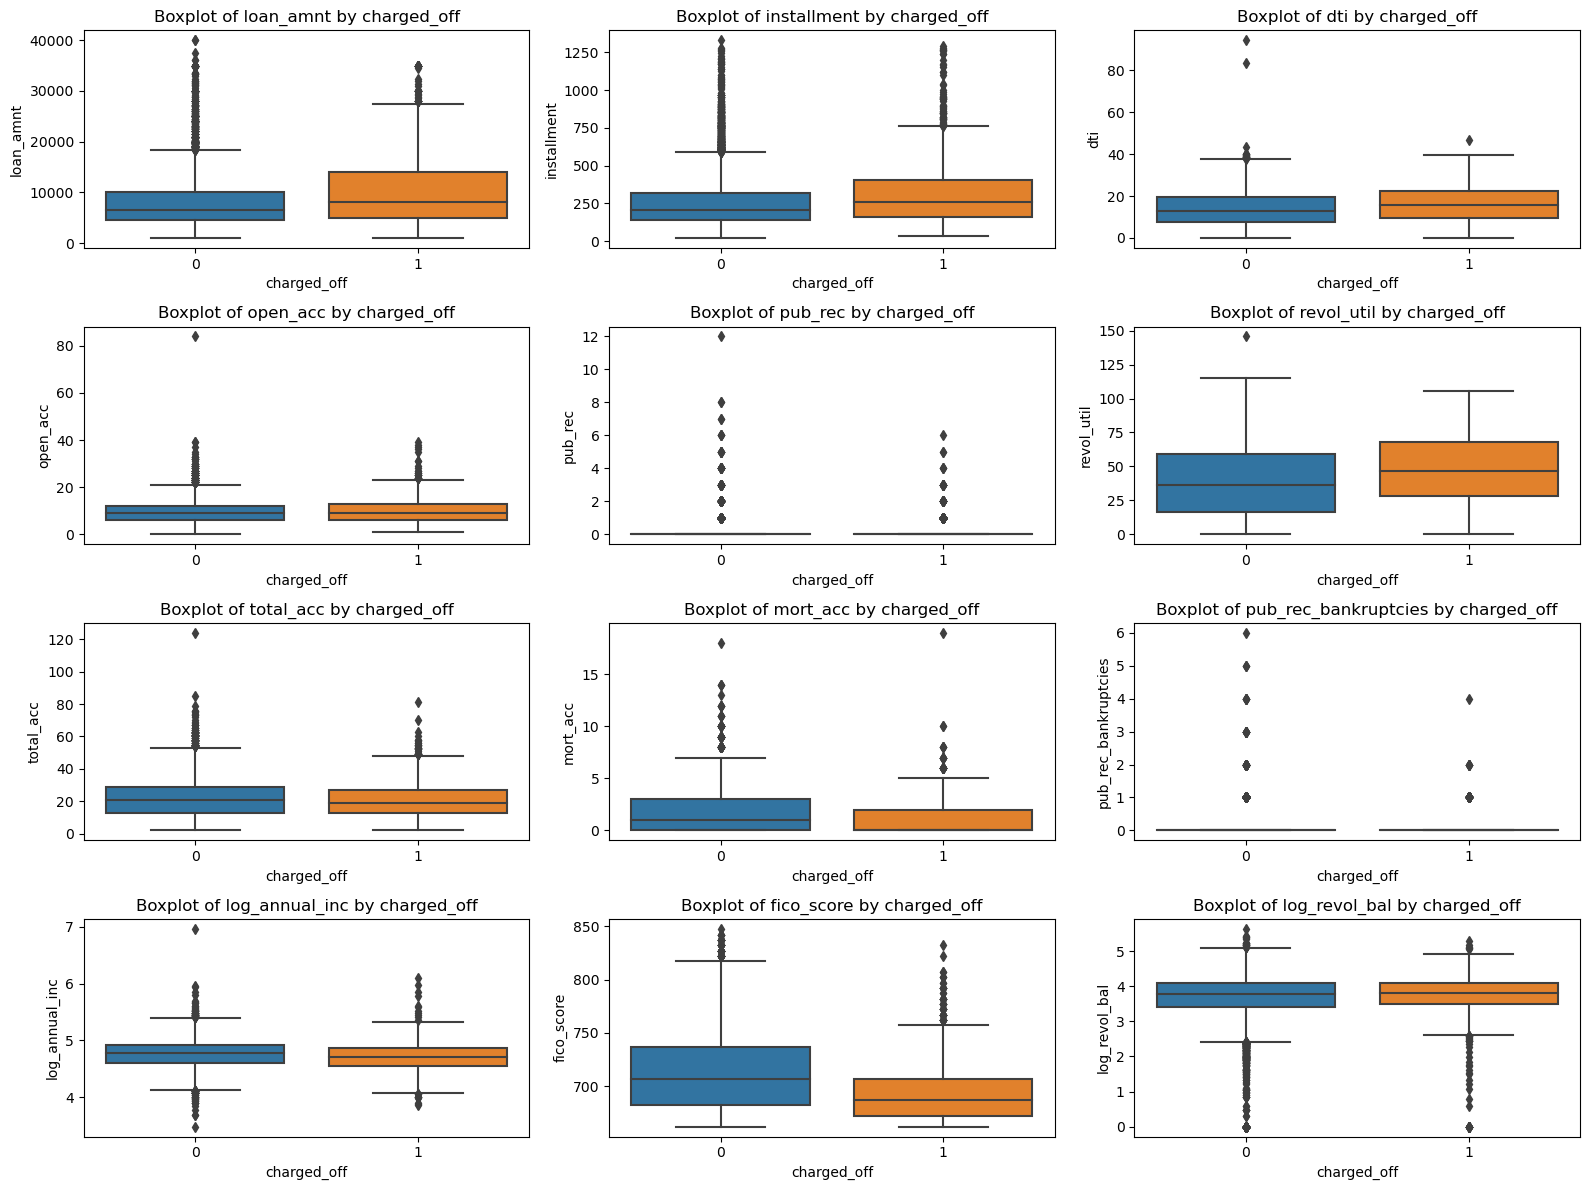

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_excel('dataset.xlsx')

# Select the specified columns
selected_columns = ['loan_amnt', 'installment', 'dti', 'open_acc', 'pub_rec', 
                    'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 
                    'log_annual_inc', 'fico_score', 'log_revol_bal', 'charged_off']

# Subset the DataFrame with selected columns
df_selected = df[selected_columns]

# Compute correlation matrix
correlation_matrix = df_selected.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# Plot box plots for numerical features grouped by charged_off
plt.figure(figsize=(16, 12))
for i, feature in enumerate(df_selected.columns[:-1], 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x='charged_off', y=feature, data=df_selected)
    plt.title(f'Boxplot of {feature} by charged_off')
plt.tight_layout()
plt.show()

### Dataset split

We split the data set into a training and a test set. Because our dataset is relatively small, we do not use a validation set (cross-validation is used for model selection). We decide to keep 85% of the dataset for training and the remaining 15% is held out for testing the model. This split allows to keep a significant proportion of the dataset for training. The split is performed such that the percentage of data for each class remains the same (i.e., 85% for non-defaulting loans and 15% for defaulting loans) in each set.

Note that we do not consider the time dependency when splitting the dataset. Another method would have been to create the test set with the 15% most recent loans. This simulates the real life environment where we create a model based on past and current information to predict the future. 

In [104]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming df is your original DataFrame
column_names = df.drop('charged_off', axis=1).columns.tolist()

# Separate input and output
y = df['charged_off'].values
X = df.drop('charged_off', axis=1).values

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)



In [105]:
X_train

array([[7.0000e+03, 3.6000e+01, 2.3583e+02, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.5000e+04, 3.6000e+01, 5.0534e+02, ..., 1.0000e+00, 1.0000e+00,
        0.0000e+00],
       [7.5000e+03, 3.6000e+01, 2.4722e+02, ..., 1.0000e+00, 1.0000e+00,
        0.0000e+00],
       ...,
       [5.0000e+03, 3.6000e+01, 1.6529e+02, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [5.6000e+03, 6.0000e+01, 1.1166e+02, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [1.7600e+04, 3.6000e+01, 5.3487e+02, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00]])

### Feature scaling

Finally, we scale the features such that their respective mean is zero and their respective standard deviation is one. Mathematically, the transformation is performed according to

\begin{equation}
    z_{i, j} = \frac{x_{i, j} - \mu_{j}}{\sigma_{j}},  \,\,\, i = 1,2,...,N, \,\,\, j = 1, 2,..., p
\end{equation}    

where $N$ is the number of loans, $p$ is the number of features, $z_{i, j}$ is the normalized value of feature $j$ for loan $i$, $x_{i, j}$ is the value of feature $j$ for loan $i$, $\mu_{j}$ is the mean of feature $j$ and $\sigma_j$ is the standard deviation of feature $j$.

Note that all the models we use do not necessarily require feature scaling. For example, tree-based methods such as random forest or gradient boosting are not affected by monotonic transformations of the data. 

In [67]:
df.dtypes

loan_amnt                                int64
term                                     int64
installment                            float64
emp_length                             float64
dti                                    float64
open_acc                                 int64
pub_rec                                  int64
revol_util                             float64
total_acc                                int64
pub_rec_bankruptcies                   float64
log_annual_inc                         float64
fico_score                             float64
log_revol_bal                          float64
charged_off                              int64
yr_since_earliest_cr_line                int64
home_ownership_OWN                       uint8
home_ownership_RENT                      uint8
verification_status_Source Verified      uint8
verification_status_Verified             uint8
dtype: object

In [68]:
# Feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Class imbalance mitigation

As previously discussed, our dataset is imbalanced (15% of data in the positive class). To prevent the learners from exhibiting bias towards the majority class, we need to mitigate class imbalance. Here, we decide to balance the class weights at the time of fitting the models. Balanced class weights are computed as

\begin{align}
    w_0 &= \frac{1}{n_0} \frac{(n_0 + n_1)}{2} \\
    w_1 &= \frac{1}{n_1} \frac{(n_0 + n_1)}{2}
\end{align}

where $w_i$ is the weight for class $i$ and $n_i$ is the number of samples for class $i$. Herein, we will use those class weights directly. However, it also would be possible to optimize them with cross-validation. 

In [69]:
# Compute balanced class weights
weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights = {0:weights[0], 1:weights[1]}

print('Balanced weights are given by: ' + str(weights))

Balanced weights are given by: {0: 0.586838849365914, 1: 3.3788958147818344}


Above we computed the class weights using the ```Scikit-learn``` package. Let's confirm that we obtain the same weights with our formulas. 

In [70]:
# Positive and negative class counts
pos = len(y_train[y_train == 1])
neg = len(y_train[y_train == 0])
total = neg + pos

# Compute weights
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Balanced weights are given by: ' + str(class_weight))

Balanced weights are given by: {0: 0.586838849365914, 1: 3.3788958147818344}


## Logistic regression

### Hyperparameter tuning



In [71]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Define logistic regression model
lr = LogisticRegression(solver='liblinear', class_weight='balanced')

# Define parameter grid for hyperparameter tuning
param_grid = {
    'C': np.logspace(-3, 3, 7)  # Regularization strength (inverse of regularization strength)
}

# Define scoring metrics for GridSearchCV
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro')
}

# Instantiate GridSearchCV with logistic regression model, parameter grid, scoring metrics, and cross-validation
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, scoring=scoring, cv=5, refit='f1')

# Fit GridSearchCV to training data
grid_search.fit(X_train, y_train)

# Print best hyperparameters
print('Best hyperparameters:')
print(grid_search.best_params_)

# Evaluate best model on test data using different metrics
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print('Evaluation metrics on test data:')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='macro'))
print('Recall:', recall_score(y_test, y_pred, average='macro'))
print('F1-score:', f1_score(y_test, y_pred, average='macro'))


Best hyperparameters:
{'C': 100.0}
Evaluation metrics on test data:
Accuracy: 0.6492537313432836
Precision: 0.5880336208803362
Recall: 0.6689752162606803
F1-score: 0.5634767709757105


## Random forest

### Hyperparameter tuning



In [74]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Define Random Forest classifier with balanced class weights
rf = RandomForestClassifier(class_weight='balanced')

# Define parameter distributions for hyperparameter tuning
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [1, 2, 3, 4, 'sqrt', 'log2', None]  # Valid options for max_features
}

# Define scoring metrics for RandomizedSearchCV
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro')
}

# Instantiate RandomizedSearchCV with optimized parameters
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, scoring=scoring,
                                   n_iter=10, cv=3, refit='f1', random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV to training data
random_search.fit(X_train, y_train)

# Print best hyperparameters
print('Best hyperparameters:')
print(random_search.best_params_)

# Evaluate best model on test data using different metrics
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print evaluation metrics on test data
print('Evaluation metrics on test data:')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='macro'))
print('Recall:', recall_score(y_test, y_pred, average='macro'))
print('F1-score:', f1_score(y_test, y_pred, average='macro'))

Best hyperparameters:
{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 1, 'max_depth': 40}
Evaluation metrics on test data:
Accuracy: 0.8485074626865672
Precision: 0.6703389915578354
Recall: 0.5750455518406482
F1-score: 0.5913351391386519
